# Conditional Linear Gaussian models

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn_vs_bn as gcm

import pyAgrum.clg as gclg
import pyAgrum.clg.notebook as gclgnb


## Build a CLG model 

### From scratch

Suppose we want to build a CLG with these specifications $A={\cal N}(5,1)$, $B={\cal N}(4,3)$ and $C=2.A+3.B+{\cal N}(3,2)$

In [2]:
model=gclg.CLG()
model.add(gclg.GaussianVariable("A",5,1))
model.add(gclg.GaussianVariable("C",3,2))
model.add(gclg.GaussianVariable("B",4,3))
model.addArc("A","C",2)
model.addArc("B","C",3)
model

CLG{nodes: 3, arcs: 2, parameters: 8}

### From SEM (Structural Equation Model)

We can create a Conditional Linear Gaussian Bayesian networ(CLG model) using a SEM-like syntax. 

`A = 4.5 [0.3]` means that the mean of the distribution for Gaussian random variable A is 4.5 and ist standard deviation is 0.3. 

`B = 3 + 0.8F [0.3]` means that the mean of the distribution for the Gaussian random variable B is 3 and the standard deviation is 0.3.  

`pyAgrum.CLG.SEM` is a set of static methods to manipulate this kind of SEM.


In [3]:
sem2="""
A=4.5 [0.3] # comments are allowed
F=7 [0.5]
B=3 + 1.2F [0.3]
C=9 +  2A + 1.5B [0.6]
D=9 + C + F[0.7]
E=9 + D [0.9]
"""

model2 = gclg.SEM.toclg(sem2)

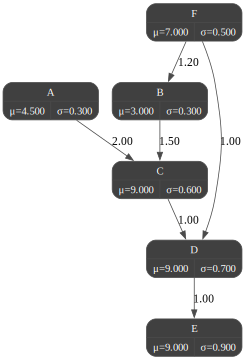

In [4]:
gnb.show(model2)

One can of course build the SEM from a CLG using `pyAgrum.CLG.SEM.tosem`  :

In [5]:
gnb.flow.row(model,"<pre><div align='left'>"+gclg.SEM.tosem(model)+"</div></pre>",
             captions=["the first CLG model","the SEM from the CLG"])

And this SEM allows of course input/output format for CLG

In [6]:
gclg.SEM.saveCLG(model2,"out/model2.sem")

print("=== file content ===")
with open("out/model2.sem","r") as file:
  for line in file.readlines():
      print(line,end="")
print("====================")

=== file content ===
F=7.0[0.5]
B=3.0+1.2F[0.3]
A=4.5[0.3]
C=9.0+2.0A+1.5B[0.6]
D=9.0+F+C[0.7]
E=9.0+D[0.9]


In [7]:
model3=gclg.SEM.loadCLG("out/model2.sem")
gnb.sideBySide(model2,model3,captions=["saved model","loaded model"])

## input/output with pickle

In [8]:
import pickle
with open("test.pkl","bw") as f:
  pickle.dump(model3,f)
model3

CLG{nodes: 6, arcs: 6, parameters: 18}

In [9]:
with open("test.pkl","br") as f:
  copyModel3=pickle.load(f)
copyModel3

CLG{nodes: 6, arcs: 6, parameters: 18}

## Exact or approximated Inference

### Exact inference : Variable Elimination

Compute some posterior using difference exact inference

In [10]:
ie=gclg.CLGVariableElimination(model2)
ie.updateEvidence({"D":3})

print(ie.posterior("A"))
print(ie.posterior("B"))
print(ie.posterior("C"))
print(ie.posterior("D"))
print(ie.posterior("E"))
print(ie.posterior("F"))


v=ie.posterior("E")
print(v)
print(f"  - mean(E|D=3)={v.mu()}")
print(f"  - stdev(E|D=3)={v.sigma()}")

A:1.9327650111193468[0.28353638852446156]
B:-2.5058561897702[0.41002992170553515]
C:3.9722757598220895[0.5657771474513671]
D:3[0]
E:12.0[0.9]
F:-2.9836916234247597[0.32358490464094586]
E:12.0[0.9]
  - mean(E|D=3)=12.0
  - stdev(E|D=3)=0.9


In [11]:
gnb.sideBySide(model2,gclgnb.getInference(model2,evs={"D":3},size="3!"),gclgnb.getInference(model2,evs={"D":3,"F":1}),
              captions=["The CLG","First inference","Second inference"])

### Approximated inference : MonteCarlo Sampling

When the model is too complex for exact infernece, we can use forward sampling to generate 5000 samples from the original CLG model. 

In [12]:
fs = gclg.ForwardSampling(model2)
fs.makeSample(5000).tocsv("./out/model2.csv")

We will use the generated database to do learning. But before, we can also compute posterior but without evidence :

In [13]:
ie=gclg.CLGVariableElimination(model2)
print("| 'Exact' inference                        | Results from sampling                    |")
print("|------------------------------------------|------------------------------------------|")
for i in model2.names():
    print(f"| {str(ie.posterior(i)):40} | {str(gclg.GaussianVariable(i,fs.mean_sample(i),fs.stddev_sample(i))):40} |")

| 'Exact' inference                        | Results from sampling                    |
|------------------------------------------|------------------------------------------|
| A:4.499999999999998[0.3]                 | A:4.502363024169802[0.3036745541350688]  |
| F:7.000000000000008[0.5000000000000002]  | F:6.996457547190566[0.5047526239929775]  |
| B:11.399999999999999[0.6708203932499367] | B:11.395468084089094[0.6767485530521845] |
| C:35.099999999999994[1.3162446581088183] | C:35.11191960486344[1.3237822638375893]  |
| D:51.10000000000002[1.8364367672206963]  | D:51.10560364380086[1.8559870614893375]  |
| E:60.100000000000016[2.0451161336217565] | E:60.095007796503175[2.0400481268440025] |


Now with the generated database and the original model, we can calculate the log-likelihood of the model.

In [14]:
print("log-likelihood w.r.t orignal model : ", model2.logLikelihood("./out/model2.csv"))

log-likelihood w.r.t orignal model : 

 -22179.640208993103


## Learning a CLG from data

Use the generated database to do our RAvel Learning. This part needs some time to run.

In [15]:
# RAveL learning
learner = gclg.CLGLearner("./out/model2.csv")

We can get the learned_clg model with function learn_clg() which contains structure learning and parameter estimation.

In [16]:
learned_clg = learner.learnCLG()
gnb.sideBySide(model2,learned_clg,
              captions=['original CLG','learned CLG'])

Compare the learned model's structure with that of the original model'.

In [17]:
cmp=gcm.GraphicalBNComparator(model2,learned_clg)
print(f"F-score(original_clg,learned_clg) : {cmp.scores()['fscore']}")

F-score(original_clg,learned_clg) : 0.6666666666666666


Get the learned model's parameters and compare them with the original model's parameters using the SEM syntax.

In [18]:
gnb.flow.row("<pre><div align='left'>"+gclg.SEM.tosem(model2)+"</div></pre>",
             "<pre><div align='left'>"+gclg.SEM.tosem(learned_clg)+"</div></pre>",
             captions=["original sem","learned sem"])

We can algo do parameter estimation only with function fitParameters() if we already have the structure of the model.

In [19]:
# We can copy the original CLG
copy_original = gclg.CLG(model2)

# RAveL learning again
RAveL_l = gclg.CLGLearner("./out/model2.csv")

# Fit the parameters of the copy clg
RAveL_l.fitParameters(copy_original)

copy_original

CLG{nodes: 6, arcs: 6, parameters: 18}

## Compare two CLG models

We first create two CLG from two SEMs.

In [20]:
# TWO DIFFERENT CLGs

# FIRST CLG
clg1=gclg.SEM.toclg("""
# hyper parameters
A=4[1]
B=3[5]
C=-2[5]

#equations
D=A[.2] # D is a noisy version of A
E=1+D+2B [2]
F=E+C+B+E [0.001]
""")

# SECOND CLG
clg2=gclg.SEM.toclg("""
# hyper parameters
A=4[1]
B=3+A[5]
C=-2+2B+A[5]

#equations
D=A[.2] # D is a noisy version of A
E=1+D+2B [2]
F=E+C [0.001]
""")

This cell shows how to have a quick view of the differences 

In [21]:
print(gum.config)

[core]
  default_maxnumberofthreads = 24
[notebook]
  potential_visible_digits = 4
  potential_with_colors = True
  potential_color_0 = #FF7F64
  potential_color_1 = #7FFF64
  potential_with_fraction = False
  potential_fraction_limit = 50
  potential_fraction_round_error = 1e-6
  potential_fraction_with_latex = True
  histogram_horizontal_visible_digits = 2
  histogram_vertical_visible_digits = 2
  histogram_horizontal_threshold = 8
  histogram_line_threshold = 40
  histogram_color = darkseagreen
  histogram_edge_color = darkgreen
  histogram_use_percent = True
  histogram_discretized_visualisation = histogram
  histogram_discretized_scale = 1.0
  histogram_mode = compact
  histogram_epsilon = 1e-8
  potential_parent_values = merge
  figure_facecolor = #E0E0E0
  flow_background_color = transparent
  flow_border_color = transparent
  flow_border_width = 0
  graph_format = svg
  show_inference_time = True
  default_arc_color = #4A4A4A
  default_node_bgcolor = #404040
  default_node_fgco

In [22]:
gnb.flow.row(clg1,clg2,gcm.graphDiff(clg1,clg2),
             gcm.graphDiffLegend(),
             gcm.graphDiff(clg2,clg1))

We compare the CLG models.

In [23]:
# We use the F-score to compare the two CLGs
cmp=gcm.GraphicalBNComparator(clg1,clg1)
print(f"F-score(clg1,clg1) : {cmp.scores()['fscore']}")

cmp=gcm.GraphicalBNComparator(clg1,clg2)
print(f"F-score(clg1,clg2) : {cmp.scores()['fscore']}")


F-score(clg1,clg1) : 1.0
F-score(clg1,clg2) : 0.7142857142857143


In [24]:
# The complete list of structural scores is :
print("score(clg1,clg2) :")
for score,val in cmp.scores().items():
  print(f"  - {score} : {val}")

score(clg1,clg2) :
  - count : {'tp': 5, 'tn': 21, 'fp': 3, 'fn': 1}
  - recall : 0.8333333333333334
  - precision : 0.625
  - fscore : 0.7142857142857143
  - dist2opt : 0.41036907507483766


## Forward Sampling

In [25]:
# We create a simple CLG with 3 variables
clg = gclg.CLG()
# prog=« sigma=2;X=N(5);Y=N(3);Z=X+Y »
A = gclg.GaussianVariable(mu=2, sigma=1, name='A')
B = gclg.GaussianVariable(mu=1, sigma=2, name='B')
C = gclg.GaussianVariable(mu=2, sigma=3, name='C')
  
idA = clg.add(A)
idB = clg.add(B)
idC = clg.add(C)

clg.addArc(idA, idB, 1.5)
clg.addArc(idB, idC, 0.75)

# We can show it as a graph
original_clg = gclgnb.CLG2dot(clg)
original_clg

In [26]:
fs = gclg.ForwardSampling(clg)
fs.makeSample(10)

In [27]:
print("A's sample_variance: ", fs.variance_sample(0))
print("B's sample_variance: ", fs.variance_sample('B'))
print("C's sample_variance: ", fs.variance_sample(2))

A's sample_variance:  0.42342322842206004
B's sample_variance:  6.498064948578582
C's sample_variance:  11.149870887296805


In [28]:
print("A's sample_mean: ", fs.mean_sample('A'))
print("B's sample_mean: ", fs.mean_sample('B'))
print("C's sample_mean: ", fs.mean_sample('C'))

A's sample_mean:  1.9929620169987534
B's sample_mean:  4.503100699918417
C's sample_mean:  5.706727657782962


In [29]:
fs.toarray()

array([[ 1.23883751,  1.17686467,  1.12420003],
       [ 2.48183731,  4.81084019,  6.99692555],
       [ 1.18582355,  5.66586213, 11.28495059],
       [ 1.59743112,  0.69401504,  2.28371226],
       [ 1.85195856,  5.39300381,  5.74532108],
       [ 1.98001931,  3.45440182,  3.51062802],
       [ 3.06546191,  7.66348816, 11.52314793],
       [ 2.89189006,  9.32051452,  6.69346805],
       [ 2.35629654,  2.89995015,  4.28207469],
       [ 1.2800643 ,  3.95206649,  3.62284839]])

In [30]:
# export to dataframe
fs.topandas()

,A,B,C
0,1.238838,1.176865,1.124200
1,2.481837,4.810840,6.996926
2,1.185824,5.665862,11.284951
3,1.597431,0.694015,2.283712
4,1.851959,5.393004,5.745321
5,1.980019,3.454402,3.510628
6,3.065462,7.663488,11.523148
7,2.891890,9.320515,6.693468
8,2.356297,2.899950,4.282075
9,1.280064,3.952066,3.622848


In [31]:
# export to csv
fs.makeSample(10000)
fs.tocsv('./out/samples.csv')

## PC-algorithm & Parameter Estimation

The module allows to investigale more deeply into the learning algorithm.

We first create a random CLG model with 5 variables.

In [32]:
# Create a new random CLG
clg = gclg.randomCLG(nb_variables=5, names="ABCDE")

# Display the CLG
print(clg)

CLG{nodes: 5, arcs: 5, parameters: 15}


We then do the Forward Sampling and CLGLearner.

In [33]:
n = 20 # n is the selected values of MC number n in n-MCERA
K = 10000 # K is the list of selected values of number of samples
Delta = 0.05 # Delta is the FWER we want to control

# Sample generation
fs = gclg.ForwardSampling(clg)
fs.makeSample(K).tocsv('./out/clg.csv')

# Learning
RAveL_l = gclg.CLGLearner('./out/clg.csv',n_sample=n,fwer_delta=Delta)

We use the PC algorithme to learn the structure of the model.

In [34]:
# Use the PC algorithm to get the skeleton
C = RAveL_l.PC_algorithm(order=clg.nodes(), verbose=False)
print("The final skeleton is:\n", C)

The final skeleton is:
 {0: {2}, 1: {2, 3}, 2: set(), 3: set(), 4: set()}


In [35]:
# Create a Mixedgraph to display the skeleton
RAveL_MixGraph = gum.MixedGraph()

# Add variables
for i in range(len(clg.names())):
  RAveL_MixGraph.addNodeWithId(i)

# Add arcs and edges
for father, kids in C.items():
  for kid in kids:
    if father in C[kid]:
      RAveL_MixGraph.addEdge(father, kid)
    else:
      RAveL_MixGraph.addArc(father, kid)

RAveL_MixGraph

(pyAgrum.MixedGraph@0x11900a000) {0,1,2,3,4} , {1->3,0->2,1->2} , {}

In [36]:
# Create a BN with the same structure as the CLG
bn = gum.BayesNet()
# add variables
for name in clg.names():
  new_variable = gum.LabelizedVariable(name,'a labelized variable',2)
  bn.add(new_variable)
# add arcs
for arc in clg.arcs():
  bn.addArc(arc[0], arc[1])

# Compare the result above with the EssentialGraph
Real_EssentialGraph = gum.EssentialGraph(bn)

Real_EssentialGraph

<pyAgrum.pyAgrum.EssentialGraph; proxy of <Swig Object of type 'gum::EssentialGraph *' at 0x118cc3420> >

In [37]:
# create a CLG from the skeleton of PC algorithm
clg_PC = gclg.CLG()
for node in clg.nodes():
  clg_PC.add(clg.variable(node))
for father,kids in C.items():
  for kid in kids:
    clg_PC.addArc(father, kid)

# Compare the structure of the created CLG and the original CLG
print(f"F-score : {clg.CompareStructure(clg_PC)}")

F-score : 0.5


We can also do the parameter learning.

In [38]:
id2mu, id2sigma, arc2coef = RAveL_l.estimate_parameters(C)

for node in clg.nodes():
  print(f"Real Value: node {node} : mu = {clg.variable(node)._mu}, sigma = {clg.variable(node)._sigma}")
  print(f"Estimation: node {node} : mu = {id2mu[node]}, sigma = {id2sigma[node]}")


for arc in clg.arcs():
  print(f"Real Value: arc {arc} : coef = {clg.coefArc(*arc)}")
  print(f"Estimation: arc {arc} : coef = {(arc2coef[arc] if arc in arc2coef else '-')}")

Real Value: node 0 : mu = -1.466848572985544, sigma = 1.9514642651358898
Estimation: node 0 : mu = -1.477800164365639, sigma = 1.9452271398161107
Real Value: node 1 : mu = 2.9199869887532524, sigma = 1.0618293117736646
Estimation: node 1 : mu = -71.75993337308283, sigma = 80.92168605727542
Real Value: node 2 : mu = 2.9355816369315493, sigma = 4.496492712039123
Estimation: node 2 : mu = 0.5365222585893274, sigma = 0.19221279933838867
Real Value: node 3 : mu = 2.4592840967453977, sigma = 7.410140817711454
Estimation: node 3 : mu = 10.966766311109211, sigma = 22.012372950956188
Real Value: node 4 : mu = -1.5686837870467354, sigma = 3.935343144759555
Estimation: node 4 : mu = -1.5848581255944825, sigma = 3.9769747243490663
Real Value: arc (0, 1) : coef = 7.681396654035673
Estimation: arc (0, 1) : coef = -
Real Value: arc (2, 1) : coef = -5.520416583970681
Estimation: arc (2, 1) : coef = -
Real Value: arc (4, 3) : coef = -5.216928735069795
Estimation: arc (4, 3) : coef = -
Real Value: arc (